In this notebook, we create a diverse set of spatial geometries for testing purposes. These geometries are based on california county boundaries. For each polygon/multipolygon geometry, we also calculate the union / convex hull ratio, as this value is calculated by the pygcdl package when determining how to upload a geometry object.

Part 0: Load libraries and county data
Part 1: Create shapefiles, each containing a subset of CA county boundaries. Geometry types are polygon or multipolygon.
Part 2: Create one shapefile and one csv file containing point data.
Part 3: Create geojson versions of existing geometries.

Description of geometry files created in this notebook: </br>
<i>(Note: zip files contain shapefile files)</i>
- subset_counties1.zip: Five randomly selected counties, all disjoint from each other. Five rows of polygon data. Ratio = 0.124
- subset_counties2.zip: Five counties, all connected. Five rows of polygon data. Ratio = 0.909
- subset_counties3.zip: Nineteen counties, all connected except for one. Nineteen rows of polygon data. Ratio = 0.895
- subset_counties4.zip: One county, multipolygon, with three polygons (includes two islands). One row of data. Ratio = 0.53
- subset_counties5.zip: One multipolygon row with the same counties as subset 2, all connected counties. Ratio = 0.909
- subset_counties6.zip: One polygon, one county. Convex hull ratio is just below 0.8. Ratio = 0.778
- subset_counties7.zip: Two connected counties, but a funky shape with large convex hull. Two rows of polygon data. Ratio = 0.562
- subset_counties8.zip: Same counties as in subset 2 and subset 5, but split into two multipolygon rows. First row contains to disjoint counties. Ratio = 0.909
- county_centroids.zip: Point data of all CA county centroids.
- county_centroids.csv: CSV version of county_centroids.shp
- subset_counties1.geojson: Geojson version of subset_counties1.shp
- subset_counties2.geojson: Geojson version of subset_counties2.shp
- county_centroids.geojson: Geojson version of county_centroids.shp

# Part 0: Load libraries and county data

In [1]:
import geopandas as gpd
from pathlib import Path
import random
import zipfile
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import MultiPolygon
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Define paths and read in county data
random.seed(12345)
basedir = Path.cwd()
print(basedir)
input_dir = Path(basedir/ "input_data")
output_dir = basedir
counties = gpd.read_file(input_dir/"CA_Counties_TIGER2016.shp")
counties.head()

C:\Users\Noa.Mills\Documents\pygcdl\sample_data


,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,091,00277310,06091,Sierra,Sierra County,06,H1,G4020,None,None,None,A,2468694587,23299110,+39.5769252,-120.5219926,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,06,067,00277298,06067,Sacramento,Sacramento County,06,H1,G4020,472,40900,None,A,2499183617,76073827,+38.4500114,-121.3404409,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,06,083,00277306,06083,Santa Barbara,Santa Barbara County,06,H1,G4020,None,42200,None,A,7084000598,2729814515,+34.5370572,-120.0399729,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,06,009,01675885,06009,Calaveras,Calaveras County,06,H1,G4020,None,None,None,A,2641820834,43806026,+38.1838996,-120.5614415,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


In [3]:
# Remove all unnecessary columns
counties = counties[["NAME", "geometry"]]
counties.head()

,NAME,geometry
0,Sierra,"POLYGON ((-13431319.751 4821511.426, -13431312..."
1,Sacramento,"POLYGON ((-13490651.476 4680831.603, -13490511..."
2,Santa Barbara,"MULTIPOLYGON (((-13423116.772 4042044.149, -13..."
3,Calaveras,"POLYGON ((-13428575.483 4627725.228, -13428534..."
4,Ventura,"MULTIPOLYGON (((-13317853.594 3931602.414, -13..."


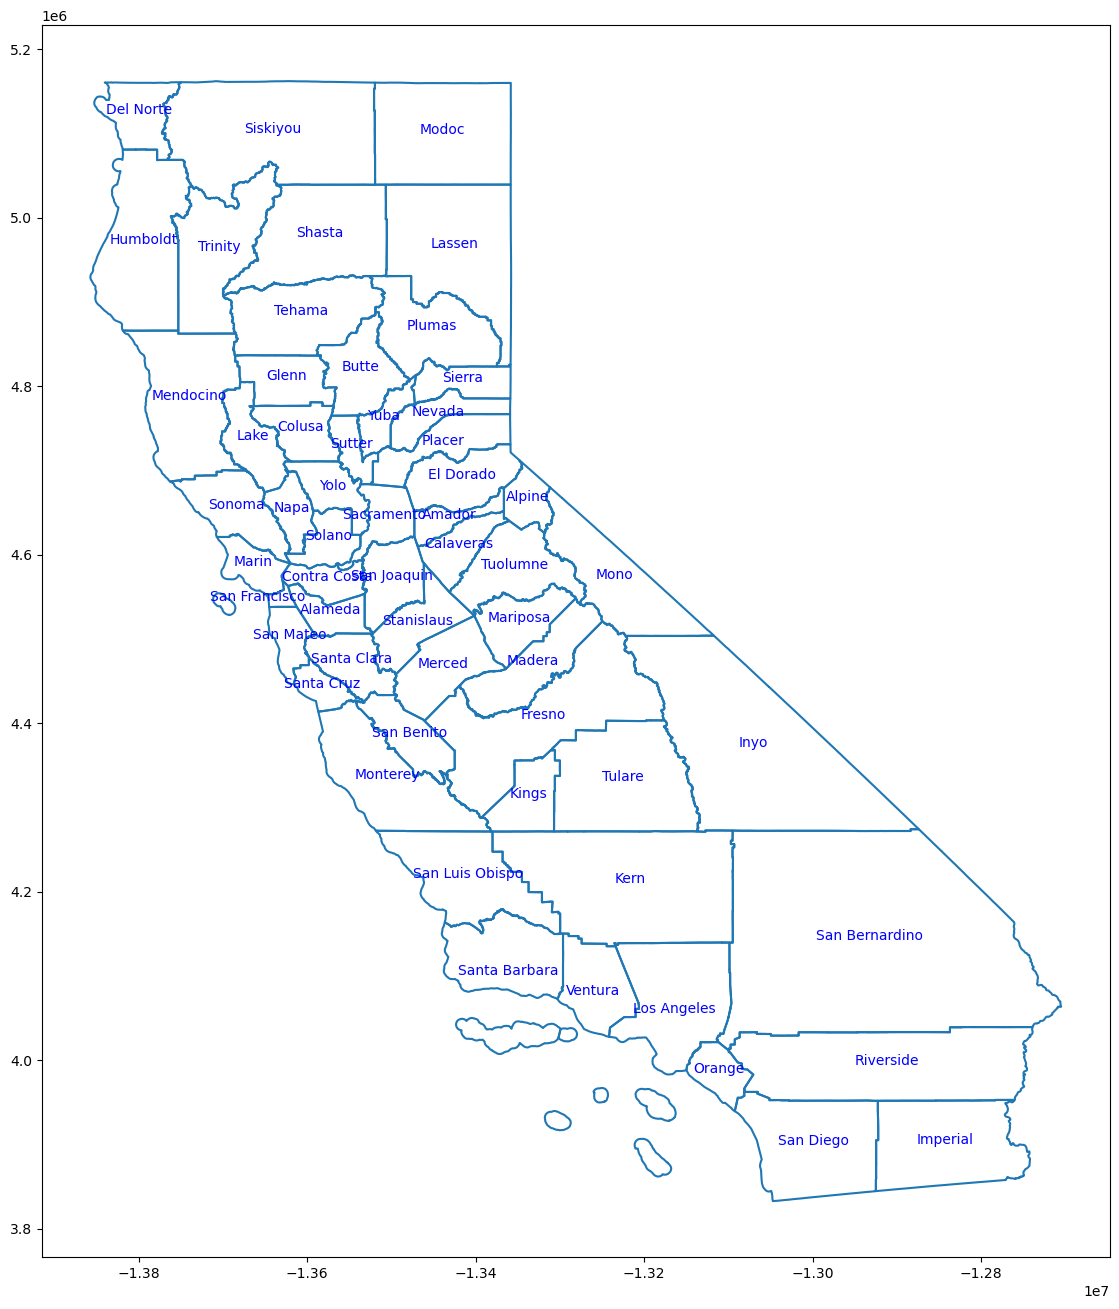

In [4]:
# Visualize all counties with county names
counties["centroid"] = counties["geometry"].centroid
fig, ax = plt.subplots(figsize=(20, 16))
counties.boundary.plot(ax=ax)
for idx, row in counties.iterrows():
    plt.annotate(text=row["NAME"], xy=(row["centroid"].x, row["centroid"].y), horizontalalignment='center', color='blue')
counties = counties.drop(["centroid"], axis=1) # remove row when done using it

In [5]:
# Define function to calculate polygon union / convex hull ratio
def union_convex_hull_ratio(gdf = gpd.GeoDataFrame):
    union_polygon = gdf.unary_union
    union_area = union_polygon.area
    convex_hull_area = union_polygon.convex_hull.area
    ratio = round(union_area / convex_hull_area, ndigits=3)
    return ratio

# Part 1: Creating county polygon subsets

##### Subset counties 1: Five randomly selected counties, all disjoint from each other. Five rows of polygon data. Ratio = 0.124

Union / Convex Hull ratio:  0.124


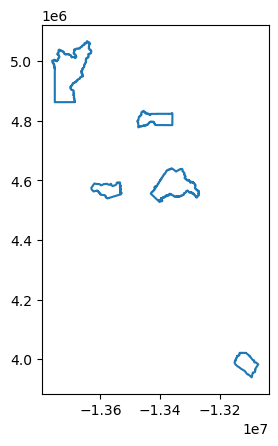

In [6]:
# Pick five random counties for subset 1 and plot them
county_indicies = range(len(counties))
county_indicies1 = random.choices(county_indicies, k=5)
subset_counties1 = counties.iloc[county_indicies1]
subset_counties1.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties1))

In [7]:
# Save shapefile files to subset_counties1.zip
subset_counties1.to_file(output_dir / "subset_counties1.shp")
zip_dir1 = output_dir / "subset_counties1.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties1.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 2

Union / Convex Hull ratio:  0.909


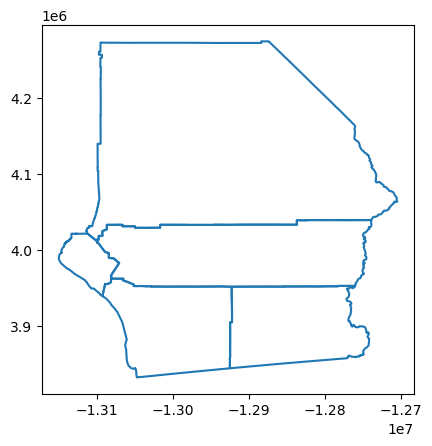

In [8]:
# Define counties in subset 2 and plot
county_names2 = ["San Bernardino", "Orange", "Riverside", "San Diego", "Imperial"]
subset_counties2 = counties[counties["NAME"].isin(county_names2)]
subset_counties2.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties2))

In [9]:
# Save shapefile files to subset_counties2.zip
subset_counties2.to_file(output_dir / "subset_counties2.shp")
zip_dir2 = output_dir / "subset_counties2.zip"
with zipfile.ZipFile(zip_dir2, "w") as z:
    for file in output_dir.glob("subset_counties2.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 3

Union / Convex Hull ratio:  0.895


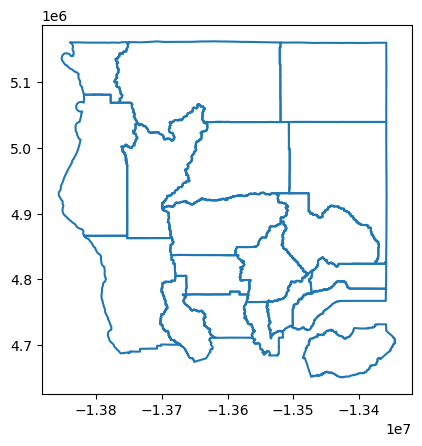

In [10]:
# Define counties in subset 3
county_names3 = ["Del Norte", "Siskiyou", "Modoc", "Humboldt", "Trinity", "Shasta", "Lassen", "Tehama", "Plumas", "Butte", "Glenn", "Mendocino", "Lake", "Colusa", "Sutter", "Yuba", "Nevada", "Sierra", "El Dorado"]
subset_counties3 = counties[counties["NAME"].isin(county_names3)]
subset_counties3.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties3))

In [11]:
# Save shapefile files to subset_counties3.zip
subset_counties3.to_file(output_dir / "subset_counties3.shp")
zip_dir1 = output_dir / "subset_counties3.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties3.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 4

Union / Convex Hull ratio:  0.53


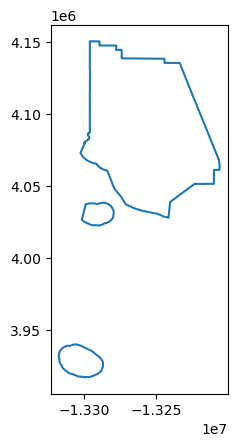

In [12]:
# Define one county for subset 4
county_names4 = ["Ventura"]
subset_counties4 = counties[counties["NAME"].isin(county_names4)]
subset_counties4.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties4))

In [13]:
# Save shapefile files to subset_counties4.zip
subset_counties4.to_file(output_dir / "subset_counties4.shp")
zip_dir1 = output_dir / "subset_counties4.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties4.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 5

Union / Convex Hull ratio:  0.909


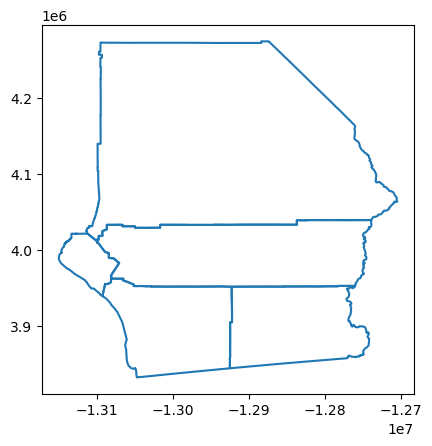

In [14]:
# Create a single multipolygon row with the same counties as subset 2, all connected
multipolygon_geometry = [subset_counties2.iloc[i, subset_counties2.columns.get_loc("geometry")] for i in range(len(subset_counties2))]
multipolygon_geometry = MultiPolygon(multipolygon_geometry)
type(multipolygon_geometry)
subset_counties5 = gpd.GeoDataFrame(index = [0], crs = subset_counties2.crs, geometry=[multipolygon_geometry])
subset_counties5.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties5))

In [15]:
# Save shapefile files to subset_counties5.zip
subset_counties5.to_file(output_dir / "subset_counties5.shp")
zip_dir1 = output_dir / "subset_counties5.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties5.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 6

Union / Convex Hull ratio:  0.778


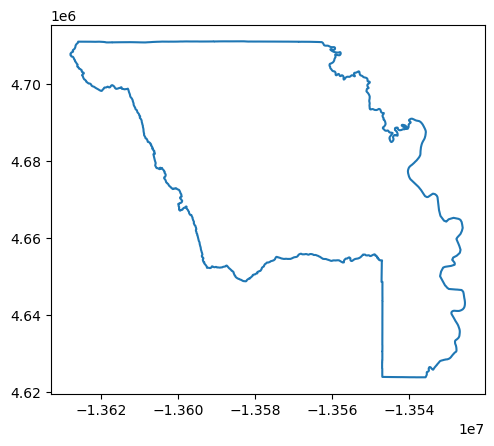

In [16]:
county_names6 = ["Yolo"]
subset_counties6 = counties[counties["NAME"].isin(county_names6)]
subset_counties6.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties6))

In [17]:
# Save shapefile files to subset_counties6.zip
subset_counties6.to_file(output_dir / "subset_counties6.shp")
zip_dir1 = output_dir / "subset_counties6.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties6.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 7

Union / Convex Hull ratio:  0.562


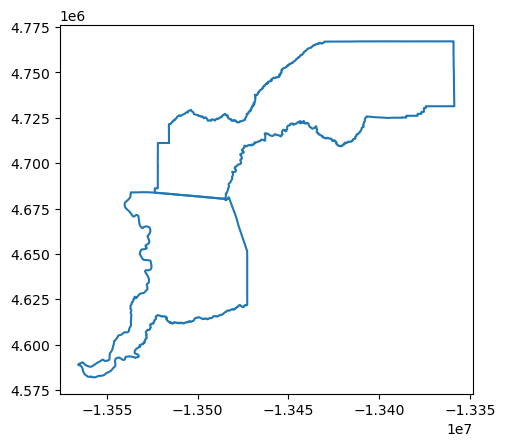

In [18]:
county_names7 = ["Placer", "Sacramento"]
subset_counties7 = counties[counties["NAME"].isin(county_names7)]
subset_counties7.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties7))

In [19]:
# Save shapefile files to subset_counties7.zip
subset_counties7.to_file(output_dir / "subset_counties7.shp")
zip_dir1 = output_dir / "subset_counties7.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties7.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

##### Subset counties 8

Union / Convex Hull ratio:  0.124


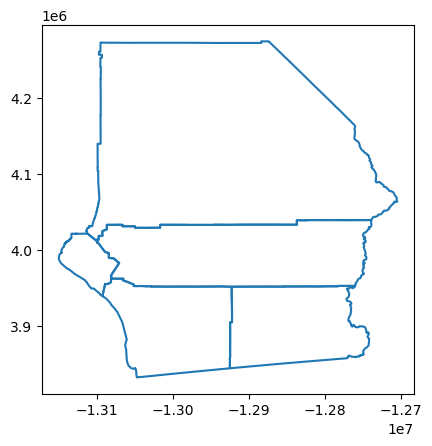

In [20]:
multipolygon_geometry1 = [subset_counties2.iloc[i, subset_counties2.columns.get_loc("geometry")] for i in [0,1]]
multipolygon_geometry1 = MultiPolygon(multipolygon_geometry1)
multipolygon_geometry2 = [subset_counties2.iloc[i, subset_counties2.columns.get_loc("geometry")] for i in [2,3,4]]
multipolygon_geometry2 = MultiPolygon(multipolygon_geometry2)
subset_counties8 = gpd.GeoDataFrame(index = [0,1], crs = subset_counties2.crs, geometry=[multipolygon_geometry1, multipolygon_geometry2])
subset_counties8.boundary.plot()
print("Union / Convex Hull ratio: ", union_convex_hull_ratio(subset_counties1))

<Axes: >

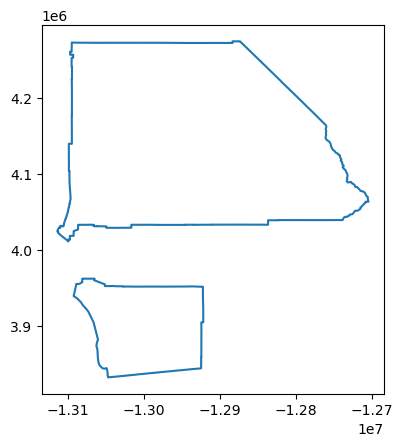

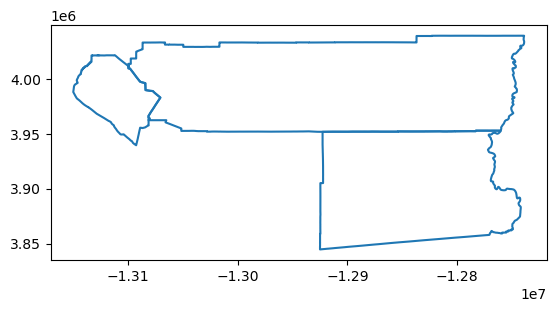

In [21]:
# Show that the first row has two disjoint polygons
subset_counties8.loc[[0],'geometry'].boundary.plot()
subset_counties8.loc[[1],'geometry'].boundary.plot()

In [22]:
# Save shapefile files to subset_counties8.zip
subset_counties8.to_file(output_dir / "subset_counties8.shp")
zip_dir1 = output_dir / "subset_counties8.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("subset_counties8.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

# Part 2: Creating Point Data

##### Make shapefile of points

<Axes: >

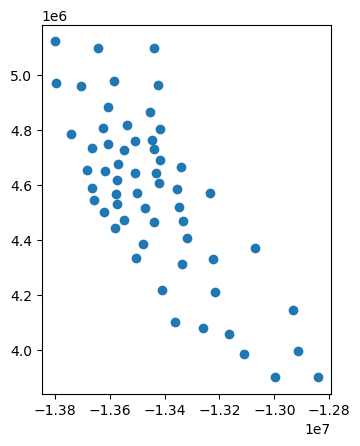

In [23]:
# Create a geodataframe of the centroids of each county
counties["centroid"] = counties["geometry"].centroid
county_centroids = counties.set_geometry("centroid")
county_centroids = county_centroids.drop(columns="geometry")
county_centroids.plot()

In [24]:
# Save shapefile files to county_centroids.zip
county_centroids.to_file(output_dir / "county_centroids.shp")
zip_dir1 = output_dir / "county_centroids.zip"
with zipfile.ZipFile(zip_dir1, "w") as z:
    for file in output_dir.glob("county_centroids.*"):
        if file != Path(z.filename):
            z.write(file, file.name)
            Path(file).unlink()

# Make csv file of points

In [25]:
print(county_centroids["centroid"].head())

0    POINT (-13415779.991 4805173.119)
1    POINT (-13507966.247 4643180.956)
2    POINT (-13361806.513 4101614.999)
3    POINT (-13419995.775 4608440.766)
4    POINT (-13261022.487 4077217.660)
Name: centroid, dtype: geometry


In [26]:
# CSV files don't contain geographic metadata, so we need to take note of the CRS our coordinates are in
# We will specify this CRS when we make our GCDL request to the GCDL knows how to interpret the coordinates
print(county_centroids.crs)

EPSG:3857


In [27]:
# Extract x and y values of points into lists
x_values = [p.x for p in county_centroids["centroid"]]
y_values = [p.y for p in county_centroids["centroid"]]

In [28]:
# Create pandas dataframe from x and y value lists
point_data = pd.DataFrame({"x":x_values, "y":y_values})
point_data.head()

,x,y
0,-1.341578e+07,4.805173e+06
1,-1.350797e+07,4.643181e+06
2,-1.336181e+07,4.101615e+06
3,-1.342000e+07,4.608441e+06
4,-1.326102e+07,4.077218e+06


In [29]:
point_data.to_csv(output_dir / "county_centroids.csv")

# Part 3: Create geojson versions of existing geometries

We will create three geojson files, based on the following existing geometry objects: subset_counties1, subset_counties2, and county_centroids.

In [30]:
subset_counties1.to_file(output_dir / "subset_counties1.geojson", driver="GeoJSON")

In [31]:
subset_counties2.to_file(output_dir / "subset_counties2.geojson", driver="GeoJSON")

In [32]:
county_centroids.to_file(output_dir / "county_centroids.geojson", driver="GeoJSON")